In [19]:
import numpy as np
import pickle
import pathlib
import pyimfit
from astropy.io import fits
import corner
import matplotlib.pyplot as plt
import pandas as pd

In [114]:
with open("../chain/chainResults/J1215+1344_MCstat_0.pkl", "rb") as file:
    d0 = pickle.load(file)    
d0

{'paramNames': ['X0_1',
  'Y0_1',
  'I_tot_1',
  'PA_2',
  'ell_bulge_2',
  'I_e_2',
  'r_e_2'],
 'params': [49.47274991098654,
  56.746711824957444,
  1377.3755386955,
  65.98579261587689,
  0.37586064592700025,
  22.935714462919297,
  10.961819721607824],
 'err': array([[8.44176189e-02, 8.34229171e-02],
        [6.52718026e-02, 6.85037533e-02],
        [1.12823339e+02, 1.12878126e+02],
        [1.31438072e+00, 1.28164101e+00],
        [1.29742298e-02, 1.36413178e-02],
        [9.01125261e-01, 8.92621438e-01],
        [2.18426667e-01, 2.24627551e-01]]),
 'fitStat': 1639.18319953714,
 'BIC': 1703.6555821409731,
 'Bayes factor': [1, 0.0]}

In [112]:
with open("../chain/chainResults/J1215+1344_MCstat_1.pkl", "rb") as file:
    d1 = pickle.load(file)    
d1

{'paramNames': ['X0_1',
  'Y0_1',
  'I_tot_1',
  'PA_2',
  'ell_bulge_2',
  'I_e_2',
  'r_e_2',
  'X0_2',
  'Y0_2',
  'I_tot_3',
  'PA_4',
  'ell_bulge_4',
  'I_e_4',
  'r_e_4'],
 'params': [53.41961217474859,
  53.52630336727806,
  2168.554118362733,
  294.66433033762956,
  0.4039571496422723,
  1.3698864832207382,
  27.48959750808799,
  48.409141960426446,
  57.65557946509293,
  1923.4826143446785,
  248.86856554097577,
  0.3803413786370472,
  15.889871995115103,
  10.783315728443817],
 'err': array([[7.71397560e-02, 8.48238589e-02],
        [8.73778904e-02, 9.41845167e-02],
        [8.38986488e+01, 7.44332231e+01],
        [5.21307471e+00, 5.88903820e+00],
        [7.31984169e-02, 7.72226233e-02],
        [2.67777057e-01, 2.80216577e-01],
        [2.80155849e+00, 3.38404963e+00],
        [7.46602359e-02, 7.30878003e-02],
        [7.08514294e-02, 6.88947795e-02],
        [1.25876441e+02, 1.09621755e+02],
        [2.24386950e+00, 2.36652764e+00],
        [2.05838182e-02, 2.25432378e-0

In [52]:
with open("../fit/fitResults/J1215+1344_fit.pkl", "rb") as file:
    d0 = pickle.load(file)    
for i in range(len(d0['bestfit_n1'][1].params)):
    print(d0['paramNames'][1][i],d0['bestfit_n1'][1].params[i])

X0_1 53.413932467974185
Y0_1 53.523473365733125
I_tot_1 2177.668533529004
PA_2 295.1240102695932
ell_bulge_2 0.4099821506408557
n_2 1.0
I_e_2 1.3643999559382238
r_e_2 27.765333608113234
X0_2 48.39925996156905
Y0_2 57.67431707622831
I_tot_3 1930.3516836039753
PA_4 248.55388292947183
ell_bulge_4 0.3827954626472631
n_4 1.0
I_e_4 15.83803896501873
r_e_4 10.805558250786275


In [3]:
def getFit(fitfile):
    fitpath = pathlib.Path.joinpath(pathlib.Path("fitResults"), fitfile)
    with open(fitpath, 'rb') as file:
        f = pickle.load(file)
    model = f['fitConfig']
    bestfits = f['fitResult']['params']
    epsf = fits.getdata("../psfConstruction/epsf2.fits")
    imageAGN = fits.getdata("agn.fits")
    psfOsamp = pyimfit.MakePsfOversampler(epsf, 4, (0,100,0,100))
    osampleList = [psfOsamp]
    fitter = pyimfit.Imfit(model,psf=epsf)
    fitter.loadData(imageAGN, psf_oversampling_list=osampleList, gain=9.942e-1, read_noise=0.22, original_sky=15.683)
    fitter.computeFitStatistic(bestfits)
    return fitter, bestfits

In [4]:
converged_sample0 = d0['chain'][:,200:,:]
converged_sample1 = d1['chain'][:,500:,:]


s0 = converged_sample0.shape
c0 = np.reshape(converged_sample0, (s0[0]*s0[1], s0[2]))

s1 = converged_sample1.shape
c1 = np.reshape(converged_sample1, (s1[0]*s1[1], s1[2]))

In [27]:
def lnPrior_func(params,imfitter,rmind):
    parameterLimits = imfitter.getParameterLimits()
    parameterLimits = [element for indx, element in enumerate(parameterLimits) if indx not in rmind]
    parameterLimits = [(0,100000) if e is None else e for e in parameterLimits]
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return  -np.inf
    return 0.0


def lnPosterior_pf(params, imfitter, lnPrior_func, rmInd, insInd):
    lnPrior = lnPrior_func(params, imfitter, rmInd)
    if not np.isfinite(lnPrior):
        return -np.inf
    params = np.insert(params,insInd,1)
    
    lnLikelihood = -0.5 * imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood


In [6]:
fitter0, bestfits0 = getFit("J1215+1344_n1m0_fit.pkl")
fitter0.computeFitStatistic(bestfits0)

PsfOversampling: starting initialization...
141
PsfOversampling: done.
PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


1639.1367163636348

In [7]:
fitter1, bestfits1 = getFit("J1215+1344_n1m1_fit.pkl")
fitter1.computeFitStatistic(bestfits1)

PsfOversampling: starting initialization...
141
PsfOversampling: done.
PsfOversampling: starting __dealloc__.
PsfOversampling: done with __dealloc__.


871.523838503407

In [8]:
rmInd = [[5],[5,13]]
insInd = [[5],[5,12]]

In [20]:
params0 = [np.percentile(c0[:,i],50) for i in range(7)]
params1 = [np.percentile(c1[:,i],50) for i in range(14)]
lnp0 = lnPosterior_pf(params0, fitter0, lnPrior_func, rmInd[0], insInd[0])
lnp1 = lnPosterior_pf(params1, fitter1, lnPrior_func, rmInd[1], insInd[1])

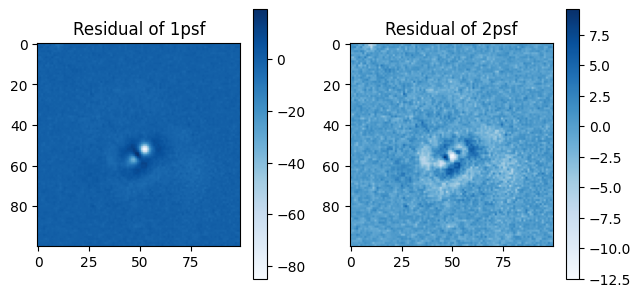

In [50]:
fig,ax = plt.subplots(1,2)
im0 = ax[0].imshow(fitter0.getModelImage(newParameters=np.insert(params0,insInd[0],1))-imageAGN, cmap="Blues")
im1= ax[1].imshow(fitter1.getModelImage(newParameters=np.insert(params1,insInd[1],1))-imageAGN, cmap="Blues")
for j, im in zip(np.arange(3), [im0,im1]):
    cbar = fig.colorbar(im, ax=ax[j], shrink=0.6)
ax[0].set_title("Residual of 1psf")
ax[1].set_title("Residual of 2psf")
fig.tight_layout()

In [51]:
# BAYES factor
np.exp(-0.5*(lnp1-lnp0))

4.6838743267609985e-84

(array([  22.,   21.,  105.,  422., 1117., 2818., 5751., 8234., 5369.,
        1141.]),
 array([-457.15454848, -455.12688348, -453.09921848, -451.07155348,
        -449.04388848, -447.01622348, -444.98855847, -442.96089347,
        -440.93322847, -438.90556347, -436.87789847]),
 <BarContainer object of 10 artists>)

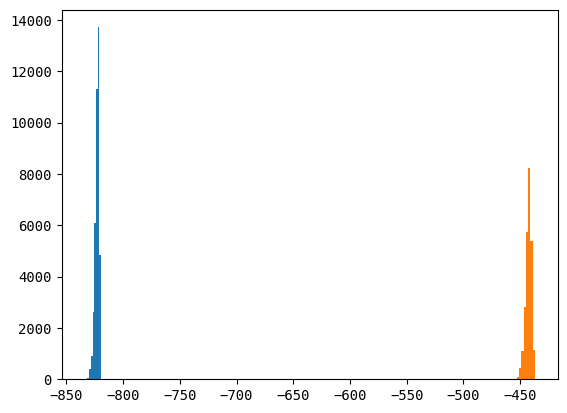

In [63]:
plt.hist(d0['flatlnprobability'][10000:])
plt.hist(d1['flatlnprobability'][25000:])

In [67]:
[np.percentile(c0[:,i],50) for i in range(7)]

[49.47151553341845,
 56.748397030049645,
 1379.3107936174722,
 65.98573450945277,
 0.37599525805030737,
 22.934438561818247,
 10.964920123929346]

In [68]:
lnPosterior_pf([np.percentile(c0[:,i],50) for i in range(7)], fitter0, lnPrior_func, rmInd[0], insInd[0])

-819.5953028630287

In [70]:
lnPosterior_pf([np.percentile(c1[:,i],50) for i in range(14)], fitter1, lnPrior_func, rmInd[1], insInd[1])

-435.8492584701315